In [6]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import gdown
import zipfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPool2D, Activation, Input, Flatten, Rescaling, concatenate, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from tensorflow.keras import activations
from keras.datasets import cifar10
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


In [7]:
"""
This code loads the CIFAR-10 dataset, normalizes the image data,
and converts the labels to one-hot encoding.
"""

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


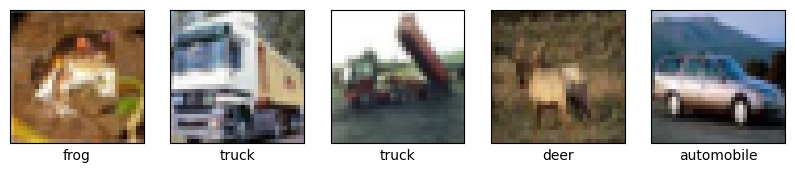

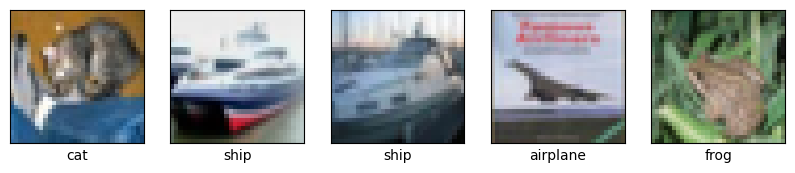

In [8]:
# define the labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# plot the first 5 images in the training set
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(cifar10_labels[tf.math.argmax(y_train[i])])
plt.show()

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(cifar10_labels[tf.math.argmax(y_test[i])])
plt.show()


In [9]:
"""
This code defines an Inception module, which is a building block of the Inception Network (or GoogLeNet).
It consists of four parallel towers (1x1 convolution, 3x3 convolution, 5x5 convolution, and 3x3 max pooling)
that operate on the same input in parallel and their outputs are concatenated together.
"""

def inception_module(model, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    tower_1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(model)

    tower_2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(model)
    tower_2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(tower_2)

    tower_3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(model)
    tower_3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(tower_3)

    tower_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(model)
    tower_4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(tower_4)

    model = concatenate([tower_1, tower_2, tower_3, tower_4], axis=3)

    return model

In [21]:
"""
This code constructs a Convolutional Neural Network (CNN) with an Inception module for image classification.
It compiles the model, and then trains it on the training data for 10 epochs.
The model's performance is evaluated on the test data during training.
"""

input_img = Input(shape=(32, 32, 3))

x = Conv2D(16, kernel_size=3, padding='same', activation='relu')(input_img)
x = MaxPooling2D(pool_size=2)(x)
x = inception_module(x, 8, 16, 32, 8, 16, 16)
x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)
# model.summary()

learning_rate = 0.0009

model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)


Epoch 1/10
1563/1563 [==============================] - 15s 8ms/step - loss: 1.4758 - accuracy: 0.4684 - val_loss: 1.2433 - val_accuracy: 0.5467
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0982 - accuracy: 0.6139 - val_loss: 1.0235 - val_accuracy: 0.6389
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9388 - accuracy: 0.6714 - val_loss: 0.9642 - val_accuracy: 0.6690
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8388 - accuracy: 0.7071 - val_loss: 0.9071 - val_accuracy: 0.6798
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7647 - accuracy: 0.7336 - val_loss: 0.8158 - val_accuracy: 0.7192
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7061 - accuracy: 0.7543 - val_loss: 0.8302 - val_accuracy: 0.7152
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6530 - accuracy: 0.7703 - val_loss: 0.8055 - val_ac

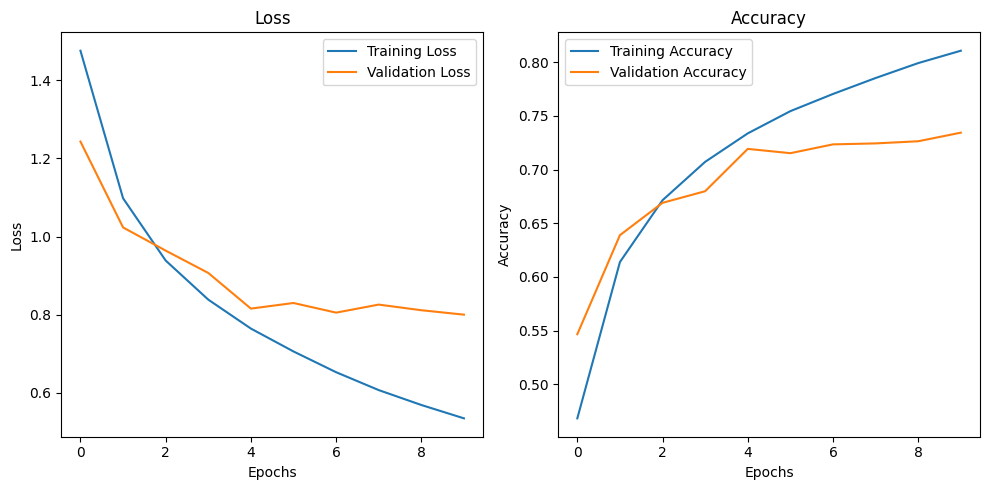

In [22]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()